# Time Series - Arima PETR4

Nesse código vamos fazer uso de séries temporais para prever os preços da ação PETR4. 
Definição de Série Temporal: é uma sequência de dados ao longo do tempo, onde as observações são capturadas em espaços de tempo
regulares. A principal motivação de usar séries temporais é para entender o processo gerador de determinado dado e também para 
"desenhar" um modelo que seja capaz de monitorar e fazer previsões sobre este processo. É importante frisar que uma série 
temporal possui três componentes: Tendência, sazonalidade e resíduo. A tendência diz respeito a direção de longo prazo da 
séries, a sazonalidade são as oscilações periodicas devido a carecterística temporal da série e o resíduo são as flutuações 
irregulares e aleatórias.

In [60]:
# Importando bibliotecas (obs: datetime para pegar dados em sites)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

In [61]:
# Importando pacote Arima
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

In [62]:
# Especificando o período da série histórica
start = dt.datetime(2015,1,1)
end = dt.datetime(2020,6,30)

In [63]:
# Importando dados do yahoo finance
petr4 = web.DataReader("PETR4.SA", "yahoo", start, end)

In [64]:
# DataFrame com os preços de: Máximo, Mínimo, Abertura, Fechamento, Volume e Preço Ajustado
petr4

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,9.990000,9.350000,9.990000,9.360000,49559500.0,8.683293
2015-01-05,9.190000,8.530000,9.140000,8.560000,78385100.0,7.941135
2015-01-06,8.830000,8.040000,8.710000,8.280000,84723300.0,7.681378
2015-01-07,8.730000,8.360000,8.560000,8.670000,85531000.0,8.043181
2015-01-08,9.390000,8.740000,8.790000,9.230000,83306300.0,8.562695
...,...,...,...,...,...,...
2020-06-24,21.559999,20.709999,21.490000,21.000000,65162400.0,20.999582
2020-06-25,21.469999,20.730000,20.910000,21.469999,47263500.0,21.469574
2020-06-26,21.469999,20.780001,21.209999,20.840000,55499300.0,20.839586


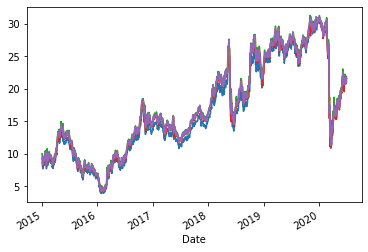

In [65]:
# Gráficos dos preços coletados
petr4["Adj Close"].plot()
petr4["Open"].plot()
petr4["High"].plot()
petr4["Low"].plot()
petr4["Close"].plot()

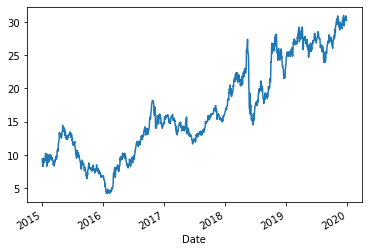

In [66]:
# Separando dados para o treino e visualizando
petr4_treino = petr4_close["2015-01-01":"2020-01-01"]
petr4_treino.plot()

In [119]:
# Tipo de dados
print(petr4_close.dtypes)

#exibindo informações do dado
print(petr4_close.info())

float64


AttributeError: 'Series' object has no attribute 'info'

In [67]:
# Existe NaNs nos dados?
print(petr4_close.isnull().values.any().sum())

0


In [68]:
# Conhecendo nossa base inteira - estatística descritiva
petr4_close.describe()

count    1363.000000
mean       17.118944
std         7.124282
min         4.200000
25%        11.920000
50%        15.670000
75%        23.959999
max        30.969999
Name: Close, dtype: float64

In [69]:
# Conhecendo os dados de treino - estatística descritiva
petr4_treino.describe()

count    1241.000000
mean       16.663739
std         7.066000
min         4.200000
25%        10.930000
50%        15.310000
75%        22.820000
max        30.969999
Name: Close, dtype: float64

A princípio as estatísticas descritivas dos dois conjuntos (treino e série completa) são bem parecidas. Essa investigação é necessária para dar início ao processo de verificar se a série é estacionária, como preoconiza a teoria.
Uma série estacionária é um processo aleatório com média e variância constante. Saber se uma série é estacionária ou não é importante para calibrar o modelo que estamos "desenhando" para fazer previsões. A seguir vamos realizar teste de estacionariedade, Augmented Dicky Fuller.

In [70]:
# Teste de Estacionariedade para toda a série
def teste_estacionariedade(serie):
    # Estatisticas de rolamento (Rolling Statistics)
    rol_mean = serie.rolling(window=12).mean()
    rol_std = serie.rolling(window=12).std()
    plt.plot(serie, color='black',label='Original')
    plt.plot(rol_mean, color='red', label='Média')
    plt.plot(rol_std, color='blue', label='Desvio Padrão')
    plt.xlabel('Data')
    plt.ylabel("R$")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return [rol_mean.index,serie,rol_mean,rol_std]

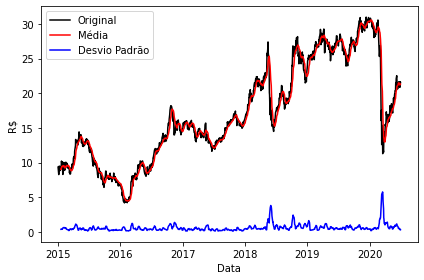

In [71]:
indice, serie, media_serie,std_serie = teste_estacionariedade(petr4_close)

In [72]:
dic_serie = {"Original" : list(serie.values), "Media" : list(media_serie.values), "STD" : list(std_serie.values)}
pd_dic_serie = pd.DataFrame(dic_serie)#,index=indice)
pd_dic_serie.to_csv("Estacionariedade.csv",index=True)

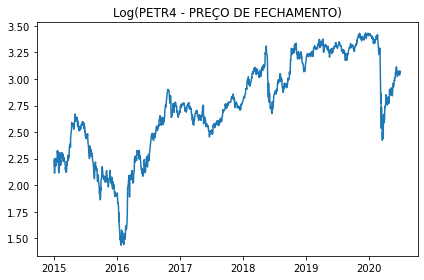

In [73]:
# Log da série
dados_log = np.log(petr4_close)
plt.title("Log(PETR4 - PREÇO DE FECHAMENTO)")
plt.plot(dados_log)
plt.tight_layout()
plt.show()

In [74]:
dados_log.to_csv("Dados_logscale.csv",index=True)

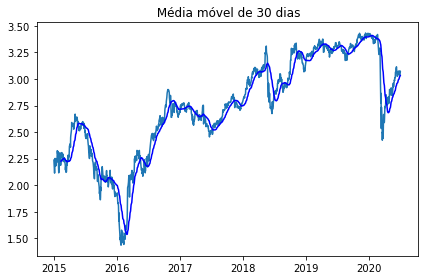

In [86]:
# Média móvel 60 dias dos dados diários - série completa
media_movel = dados_log.rolling(30).mean()
plt.plot(dados_log)
plt.title(" Média móvel de 30 dias")
plt.plot(media_movel, color='blue')
plt.tight_layout()
plt.show()

In [87]:
media_movel.to_csv("Media_Movel.csv",index=True)

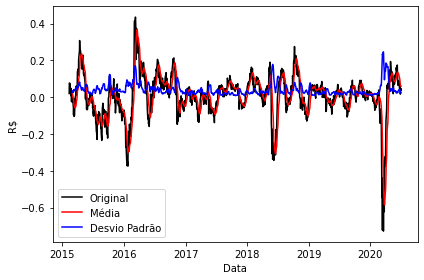

In [88]:
# Diferenciando a série
petr4_logdiff = dados_log - media_movel
petr4_logdiff.dropna(inplace=True)
indice_log, serie_log, media_serie_log,std_serie_log =teste_estacionariedade(petr4_logdiff)

In [92]:
# Observando o processo com média móvel ponderada
dados_log_exp_avg = dados_log.ewm(halflife=30).mean()

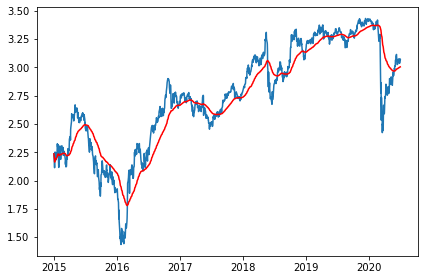

In [93]:
plt.plot(dados_log)
plt.plot(dados_log_exp_avg, color='red')
plt.tight_layout()
plt.show()

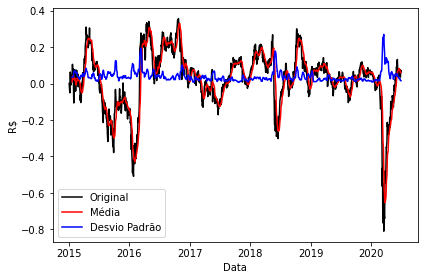

In [94]:
petr4_logdiff_ewma = dados_log - dados_log_exp_avg
indice_log_ewma, serie_log_ewma, media_serie_log_ewma,std_serie_log_ewma = teste_estacionariedade(petr4_logdiff_ewma)

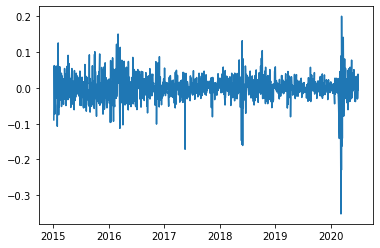

In [96]:
# Diferenciando a série
petr4_diff = dados_log - dados_log.shift()
plt.plot(dados_log_diff)
plt.show()

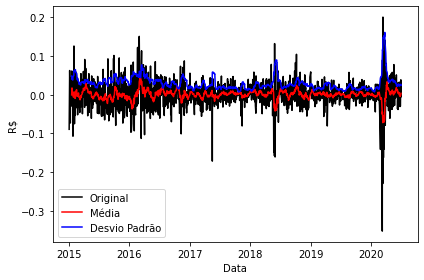

In [99]:
petr4_diff.dropna(inplace=True)
indice_log_diff, serie_log_diff, media_serie_log_diff,std_serie_log_diff =teste_estacionariedade(petr4_diff)

In [109]:
atraso_acf = acf(petr4_diff, nlags=20)
atraso_pacf = pacf(petr4_diff, nlags=20, method='ols')

In [110]:
pd_atraso_acf = pd.DataFrame(atraso_acf)
pd_atraso_pacf = pd.DataFrame(atraso_pacf)
pd_atraso_acf.to_csv("Atravo_ACF.csv",index=True)
pd_atraso_pacf.to_csv("Atravo_PACF.csv",index=True)

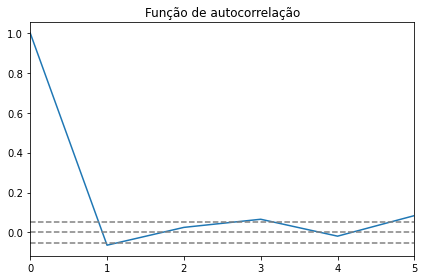

In [111]:
plt.plot(atraso_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dados_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dados_log_diff)),linestyle='--',color='gray')
plt.title('Função de autocorrelação')
plt.xlim([0,5])
plt.tight_layout()
plt.show()

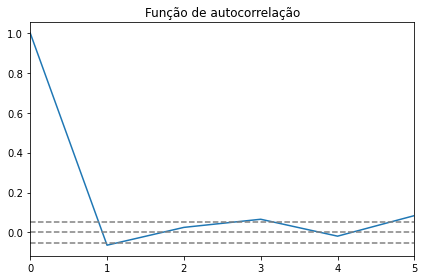

In [112]:
plt.plot(atraso_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dados_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dados_log_diff)),linestyle='--',color='gray')
plt.title('Função de autocorrelação')
plt.xlim([0,5])
plt.tight_layout()
plt.show()

In [116]:
modelo = ARIMA(np.log(petr4_close), order=(1, 0, 1), freq=petr4_close.index.inferred_freq)
modelo_fit = modelo.fit(disp=-1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
